In [1]:
# !pip install --user convertdate lunarcalendar holidays

# !pip install --user pystan==2.19.1.1 #--upgrade --force-reinstall  --no-cache

# !pip install --user prophet

# !pip install --user scikit-hts[prophet] #--upgrade --force-reinstall --no-cache

# !pip install --user plotly

In [78]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [60]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from collections import defaultdict
import hts

TIME_COL = 'TRX_DATE' #'trx_date'
TARGET_COL = 'unique_tickets'
VALIDATION_DAYS = 31

## Подгружаем датасет

In [64]:
df = pd.read_parquet('./agg_daily')

if TIME_COL == 'TRX_DATE':
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
else:
    df[TIME_COL]=pd.to_datetime(df[['trx_year', 'trx_month']].rename(
        columns={'trx_year':'YEAR','trx_month':'MONTH'}).assign(DAY=1))

df.rename(columns={'SERVICE_APP': 'app', 'SALE_CHANNEL': 'channel', 'SERVICE_CLASS': 'cl'}, inplace=True)

groups = ['app', 'channel', 'cl', 'OND', TARGET_COL]

In [5]:
print(df.shape)
df.head()

(4384827, 22)


,TRX_DATE,app,channel,cl,OND,DEST_CITY_CODE,ORIG_CITY_CODE,ORIG_REGION_CODE,DEST_REGION_CODE,TRANSFER_PRODUCT,TARIF_GROUP,OPERATING_CARRIER_CODE,OPERATING_FLIGHT_NO,coupon_count,revenue,unique_tickets,sum_days_to_trip,sum_age_years,age_info_fill_count,trx_year,trx_month,trx_date
0,2019-01-01,Android,WWW,Y,AAQ-DME,MOW,AAQ,ЮРФ,MOW,PtP,BASIC,S7,1124.0,5.0,34615.00,5.0,15.0,303.073973,5.0,2019,1,2019-01-01
1,2019-01-01,Android,WWW,Y,AAQ-DME,MOW,AAQ,ЮРФ,MOW,PtP,BASIC,S7,1128.0,5.0,37394.40,5.0,6.0,68.038356,2.0,2019,1,2019-01-01
2,2019-01-01,Android,WWW,Y,AAQ-DME,MOW,AAQ,ЮРФ,MOW,PtP,FLEX,S7,1124.0,5.0,20845.00,5.0,5.0,112.336986,5.0,2019,1,2019-01-01
3,2019-01-01,Android,WWW,Y,AAQ-DME,MOW,AAQ,ЮРФ,MOW,PtP,FLEX,S7,1128.0,1.0,4811.00,1.0,2.0,36.060274,1.0,2019,1,2019-01-01
4,2019-01-01,Android,WWW,Y,AAQ-GOJ,GOJ,MOW,MOW,ЦРФ,Transf,FLEX,S7,1.0,1.0,4278.53,1.0,0.0,0.000000,0.0,2019,1,2019-01-01


# Описание набора функицй:
## Функция для создания групповой иерархии по набору категорий из датасета

Всех следующие функции на данный момент реализованы для иерархий глубиной до 3 уровней включительно

In [6]:
def make_grouped_hierarchy_by_cols(df, cols=[]):
    if len(cols) == 0:
        hierarchy = {'total': 'total_1'}
    
    if len(cols) == 1:
        lev_1 = [f'{cols[0]}={x}' for x in df[cols[0]].unique()]
        hierarchy = {'total' : lev_1}
    
    if len(cols) == 2:
        lev_1 = [f'{cols[0]}={x}' for x in df[cols[0]].unique()]
        lev_2 = [f'{cols[1]}={x}' for x in df[cols[1]].unique()]
        
        second_level=defaultdict(set)
        for cat_1, cat_2 in itertools.product(lev_1, lev_2):
            second_level[cat_1].add(f'{cat_1}_{cat_2}')
            
        for k, v in second_level.items():
            second_level[k] = list(v)
            
        hierarchy = {'total' : lev_1 + lev_2, **second_level}
    
    if len(cols) == 3:
        lev_1 = [f'{cols[0]}={x}' for x in df[cols[0]].unique()]
        lev_2 = [f'{cols[1]}={x}' for x in df[cols[1]].unique()]
        lev_3 = [f'{cols[2]}={x}' for x in df[cols[2]].unique()]
        
        second_level=defaultdict(set)
        third_level=defaultdict(set)
        for cat_1, cat_2, cat_3 in itertools.product(lev_1, lev_2, lev_3):
            second_level[cat_1].add(f'{cat_1}_{cat_2}')
            third_level[f'{cat_1}_{cat_2}'].add(f'{cat_1}_{cat_2}_{cat_3}')
            
        for k, v in second_level.items():
            second_level[k] = list(v)
            
        for k, v in third_level.items():
            third_level[k] = list(v)
            
        hierarchy = {'total' : lev_1 + lev_2 + lev_3, **second_level, **third_level}
        
    return hierarchy

### Вот например групповая иерархия, где на первом уровне классы, а на втором - их декомпозиция на приложения. На нулевом уровне всегда total

In [7]:
make_grouped_hierarchy_by_cols(df, ['cl', 'app'])

{'total': ['cl=Y',
  'cl=C',
  'app=Android',
  'app=Iphone',
  'app=Web-mobile',
  'app=С7Б аэропорт',
  'app=С7Б город',
  'app=С7С аэропорт',
  'app=С7С город'],
 'cl=Y': ['cl=Y_app=С7Б город',
  'cl=Y_app=С7С аэропорт',
  'cl=Y_app=Android',
  'cl=Y_app=Iphone',
  'cl=Y_app=С7С город',
  'cl=Y_app=С7Б аэропорт',
  'cl=Y_app=Web-mobile'],
 'cl=C': ['cl=C_app=Iphone',
  'cl=C_app=С7Б город',
  'cl=C_app=С7Б аэропорт',
  'cl=C_app=С7С аэропорт',
  'cl=C_app=Android',
  'cl=C_app=Web-mobile',
  'cl=C_app=С7С город']}

## Функция для получения статистик по выбранным категориям

In [8]:
def make_grouped_df(df, cols=[], hierarchy=None):
    if not hierarchy:
        hierarchy = make_grouped_hierarchy_by_cols(df, cols)
    
    new = df.groupby([TIME_COL] + cols).sum().reset_index().set_index(TIME_COL)[cols + [TARGET_COL]]
    new = pd.get_dummies(new, prefix_sep='=')
    
    if len(cols) == 0:
        new = new.rename(columns={TARGET_COL: 'total'})[['total']]
        
    if len(cols) == 1:
        new = new.apply(lambda x: x * x.unique_tickets, axis=1).drop(TARGET_COL, axis=1).reset_index().groupby(TIME_COL).sum()
        
    if len(cols) == 2:
        cols_to_drop = new.columns
        second_level_dict = {k: v for k, v in hierarchy.items() if k.count(cols[0]) == 1}
        second_level_names = [item for sublist in second_level_dict.values() for item in sublist]
        
        for name in second_level_names:
            cat_1, cat_2 = name.split('_')
            new[name] = new.unique_tickets * new[cat_1] * new[cat_2]
        new = new.drop(cols_to_drop, axis=1).reset_index().groupby(TIME_COL).sum()
        
    if len(cols) == 3:
        cols_to_drop = new.columns
        third_level_dict = {k: v for k, v in hierarchy.items() if k.count(cols[0]) == 1 and k.count(cols[1]) == 1}
        third_level_names = [item for sublist in third_level_dict.values() for item in sublist]
        
        for name in third_level_names:
            cat_1, cat_2, cat_3 = name.split('_')
            new[name] = new.unique_tickets * new[cat_1] * new[cat_2] * new[cat_3]
        new = new.drop(cols_to_drop, axis=1).reset_index().groupby(TIME_COL).sum()
    return new

In [9]:
make_grouped_df(df, ['cl', 'app']).head(10)

,cl=Y_app=С7Б город,cl=Y_app=С7С аэропорт,cl=Y_app=Android,cl=Y_app=Iphone,cl=Y_app=С7С город,cl=Y_app=С7Б аэропорт,cl=Y_app=Web-mobile,cl=C_app=Iphone,cl=C_app=С7Б город,cl=C_app=С7Б аэропорт,cl=C_app=С7С аэропорт,cl=C_app=Android,cl=C_app=Web-mobile,cl=C_app=С7С город
TRX_DATE,,,,,,,,,,,,,,
2019-01-01,76.0,0.0,685.0,1235.0,0.0,65.0,1970.0,16.0,1.0,2.0,0.0,0.0,7.0,0.0
2019-01-02,274.0,0.0,1048.0,1794.0,0.0,168.0,2759.0,17.0,1.0,0.0,0.0,0.0,17.0,0.0
2019-01-03,296.0,0.0,1114.0,1636.0,0.0,160.0,2688.0,17.0,0.0,2.0,0.0,2.0,13.0,0.0
2019-01-04,341.0,0.0,954.0,1792.0,0.0,127.0,2408.0,34.0,4.0,0.0,0.0,1.0,10.0,0.0
2019-01-05,263.0,0.0,1028.0,1601.0,0.0,141.0,2407.0,21.0,3.0,4.0,0.0,0.0,6.0,0.0
2019-01-06,188.0,0.0,940.0,1707.0,0.0,116.0,2042.0,13.0,0.0,1.0,0.0,0.0,1.0,0.0
2019-01-07,206.0,0.0,894.0,1677.0,0.0,143.0,2210.0,13.0,1.0,0.0,0.0,6.0,13.0,0.0
2019-01-08,221.0,0.0,1009.0,1713.0,0.0,165.0,2095.0,27.0,2.0,0.0,0.0,5.0,14.0,0.0
2019-01-09,495.0,0.0,1301.0,2382.0,0.0,167.0,2329.0,19.0,7.0,1.0,0.0,8.0,2.0,0.0


## Функция для получения аггрегированного датасета и иерархии по выбранным категориям

In [10]:
def make_grouped_df_and_hierarchy_by_cols(df, cols=[]):
    hierarchy = make_grouped_hierarchy_by_cols(df, cols)
    
    if len(cols) == 0:
        new = pd.concat([
            make_grouped_df(df, hierarchy=hierarchy),
            make_grouped_df(df, hierarchy=hierarchy).rename(columns={'total': 'total_1'})
        ], axis=1)
        
    else:
        to_concat = [make_grouped_df(df, hierarchy=hierarchy)]
        for col in cols:
            to_concat.append(make_grouped_df(df, [col], hierarchy))
        if len(cols) > 1:
            for i in range(2, len(cols) + 1):
                to_concat.append(make_grouped_df(df, cols[:i], hierarchy))
                
        new = pd.concat(to_concat, axis=1)
        
    return new, hierarchy

### С помощью данной функции можем получить иерархию и датасет, с которыми уже работает сама библиотека

In [11]:
make_grouped_df_and_hierarchy_by_cols(df, ['cl', 'app'])[0].head(10)

,total,cl=C,cl=Y,app=Android,app=Iphone,app=Web-mobile,app=С7Б аэропорт,app=С7Б город,app=С7С аэропорт,app=С7С город,cl=Y_app=С7Б город,cl=Y_app=С7С аэропорт,cl=Y_app=Android,cl=Y_app=Iphone,cl=Y_app=С7С город,cl=Y_app=С7Б аэропорт,cl=Y_app=Web-mobile,cl=C_app=Iphone,cl=C_app=С7Б город,cl=C_app=С7Б аэропорт,cl=C_app=С7С аэропорт,cl=C_app=Android,cl=C_app=Web-mobile,cl=C_app=С7С город
TRX_DATE,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,4057.0,26.0,4031.0,685.0,1251.0,1977.0,67.0,77.0,0.0,0.0,76.0,0.0,685.0,1235.0,0.0,65.0,1970.0,16.0,1.0,2.0,0.0,0.0,7.0,0.0
2019-01-02,6078.0,35.0,6043.0,1048.0,1811.0,2776.0,168.0,275.0,0.0,0.0,274.0,0.0,1048.0,1794.0,0.0,168.0,2759.0,17.0,1.0,0.0,0.0,0.0,17.0,0.0
2019-01-03,5928.0,34.0,5894.0,1116.0,1653.0,2701.0,162.0,296.0,0.0,0.0,296.0,0.0,1114.0,1636.0,0.0,160.0,2688.0,17.0,0.0,2.0,0.0,2.0,13.0,0.0
2019-01-04,5671.0,49.0,5622.0,955.0,1826.0,2418.0,127.0,345.0,0.0,0.0,341.0,0.0,954.0,1792.0,0.0,127.0,2408.0,34.0,4.0,0.0,0.0,1.0,10.0,0.0
2019-01-05,5474.0,34.0,5440.0,1028.0,1622.0,2413.0,145.0,266.0,0.0,0.0,263.0,0.0,1028.0,1601.0,0.0,141.0,2407.0,21.0,3.0,4.0,0.0,0.0,6.0,0.0
2019-01-06,5008.0,15.0,4993.0,940.0,1720.0,2043.0,117.0,188.0,0.0,0.0,188.0,0.0,940.0,1707.0,0.0,116.0,2042.0,13.0,0.0,1.0,0.0,0.0,1.0,0.0
2019-01-07,5163.0,33.0,5130.0,900.0,1690.0,2223.0,143.0,207.0,0.0,0.0,206.0,0.0,894.0,1677.0,0.0,143.0,2210.0,13.0,1.0,0.0,0.0,6.0,13.0,0.0
2019-01-08,5251.0,48.0,5203.0,1014.0,1740.0,2109.0,165.0,223.0,0.0,0.0,221.0,0.0,1009.0,1713.0,0.0,165.0,2095.0,27.0,2.0,0.0,0.0,5.0,14.0,0.0
2019-01-09,6711.0,37.0,6674.0,1309.0,2401.0,2331.0,168.0,502.0,0.0,0.0,495.0,0.0,1301.0,2382.0,0.0,167.0,2329.0,19.0,7.0,1.0,0.0,8.0,2.0,0.0


## Функция для обучения модели из библиотеки scikit-hts и получения предсказаний на указанное число дней
В данной реализации обучается на неполном датасете (присутствует откат на VALIDATION_DAYS), чтобы на последнем кусочке данных можно было валидироваться

In [49]:
def hts_fit_predict(grouped_df, hierarchy, model='auto_arima', revision_method='OLS', validation_days=VALIDATION_DAYS):
    reg = hts.HTSRegressor(
        model=model, 
        revision_method=revision_method, # "OLS", "WLSS", "WLSV", "FP", "PHA", "AHP", "BU", "NONE"
        #weekly_seasonality = True,
        #daily_seasonality = True,
        #yearly_seasonality = True,
        n_jobs=0,
    )
    reg = reg.fit(df=grouped_df.loc[:grouped_df.index[-1] - pd.Timedelta(days=validation_days), :], nodes=hierarchy)
    preds = reg.predict(steps_ahead=validation_days)
    return preds

## Функция для сравнения графиков предсказаний и реальных данных для всех вершин иерархии

In [50]:
def plot_results(grouped_df, preds, hierarchy, validation_days=VALIDATION_DAYS):
    PLOT = ['total'] + [item for sublist in hierarchy.values() for item in sublist]

    fig, axs = plt.subplots(len(PLOT), figsize=(20, 30), sharex=True)


    for i, group in enumerate(PLOT):
        axs[i].plot(grouped_df[group], 
                lw=1.1, 
                color='#2ecc71', 
                alpha=0.8, 
                label='Truth')
        axs[i].plot(preds[group], 
                lw=1.1,
                color='#e74c3c', 
                alpha=0.8, 
                label='Prediction')
        axs[i].axvline(x=grouped_df.index[-1] - pd.Timedelta(days=validation_days)) #pd.to_datetime('2021-08-01'))
        axs[i].legend()
        axs[i].set_title(f'{group}')
    plt.show()

## Теперь можем перейти к обучению моделей

### Начнем с простой одноуровневой иерархии с разветвлением на 2 класса и посмотрим на результат предсказания

In [51]:
grouped_df, hierarchy = make_grouped_df_and_hierarchy_by_cols(df, ['cl'])

In [40]:
grouped_df.head(10)

,total,cl=C,cl=Y
TRX_DATE,,,
2019-01-01,4057.0,26.0,4031.0
2019-01-02,6078.0,35.0,6043.0
2019-01-03,5928.0,34.0,5894.0
2019-01-04,5671.0,49.0,5622.0
2019-01-05,5474.0,34.0,5440.0
2019-01-06,5008.0,15.0,4993.0
2019-01-07,5163.0,33.0,5130.0
2019-01-08,5251.0,48.0,5203.0
2019-01-09,6711.0,37.0,6674.0


In [52]:
tree = hts.hierarchy.HierarchyTree.from_nodes(hierarchy, grouped_df)
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(tree)

In [53]:
print('total')
print(tree.children)

total
[- cl=Y
, - cl=C
]


In [54]:
sum_mat

array([[1., 1.],
       [1., 0.],
       [0., 1.]])

In [55]:
preds = hts_fit_predict(grouped_df, hierarchy, model='auto_arima', revision_method='OLS')

Fitting models:   0%|          | 0/3 [00:00<?, ?it/s]/home/jovyan/.local/lib/python3.9/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/home/jovyan/.local/lib/python3.9/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/home/jovyan/.local/lib/python3.9/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
Fitting models: 100%|██████████| 3/3 [00:00<00:00, 229.23it/s]


In [56]:
preds.tail()

,total,cl=Y,cl=C
2021-08-27,17066.594160,16931.162092,135.432067
2021-08-28,17066.609045,16931.177192,135.431852
2021-08-29,17066.599377,16931.167374,135.432003
2021-08-30,17066.606206,16931.174311,135.431894
2021-08-31,17066.601715,16931.169745,135.431970


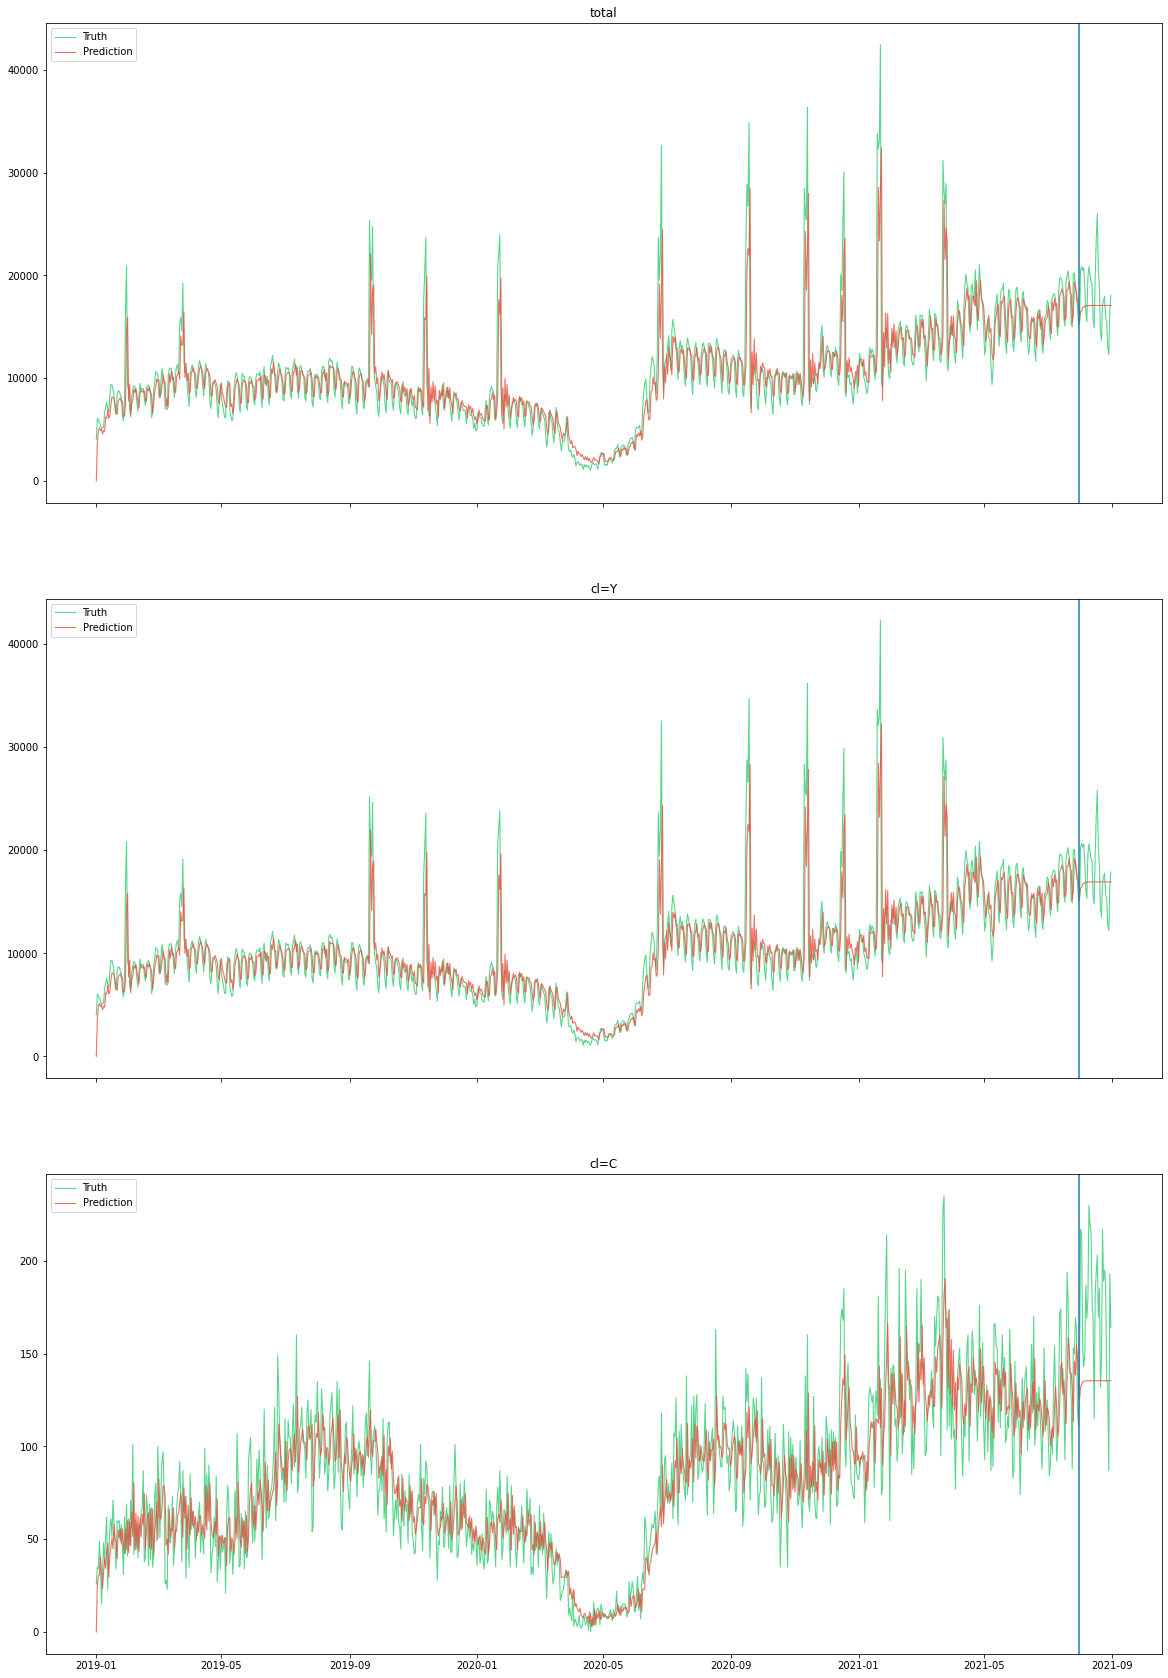

In [57]:
plot_results(grouped_df, preds, hierarchy)

### Получилось достаточно неплохо на первый взгляд, хотя бы видим, что модель улавливает тренд
### Попробуем сделать то же самое, но для категории с большим количеством уникальных значений

In [11]:
grouped_df, hierarchy = make_grouped_df_and_hierarchy_by_cols(df, ['app'])

In [12]:
preds = hts_fit_predict(grouped_df, hierarchy, model='prophet', revision_method='OLS')

Fitting models: 100%|██████████| 8/8 [00:35<00:00,  4.42s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fcb1d7b2460>


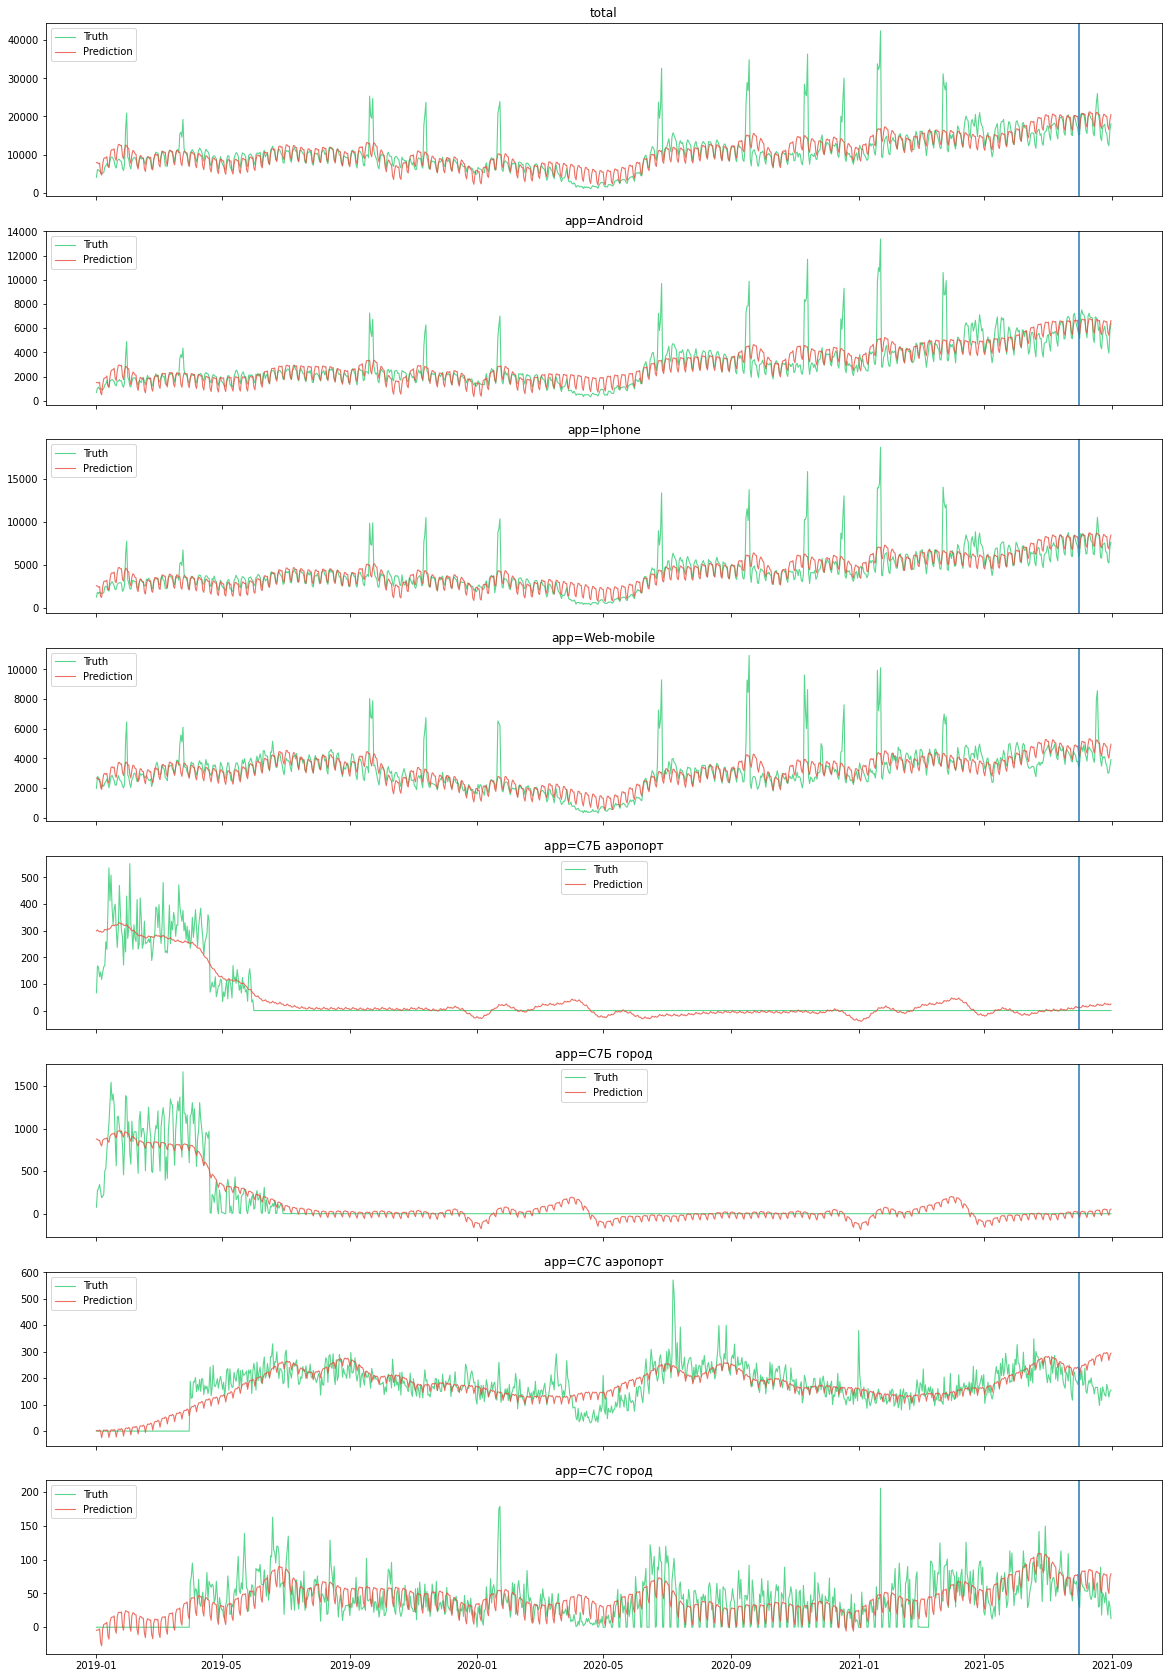

In [13]:
plot_results(grouped_df, preds, hierarchy)

### Здесь использовали prophet и можем заметить, что хоть на месяц предсказания не очень точны, но на неделю вперед модель справляется лучше, чем auto-arima. При этом сильно заметно, что чем меньше значений в категории, тем хуже получается предсказание. 
### То есть можно сделать вывод, что метод согласования bottom-up не будет давать хороших результатов, потому что обучаемся на малом кол-ве данных + при суммировании рядов ошибка будет накапливаться.

## Попробуем обучиться на двухуровевой иерархии

In [75]:
grouped_df, hierarchy = make_grouped_df_and_hierarchy_by_cols(df, ['cl', 'app'])

In [76]:
preds = hts_fit_predict(grouped_df, hierarchy, model='prophet', revision_method='OLS')

Fitting models: 100%|██████████| 24/24 [01:43<00:00,  4.33s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7f95884177c0>


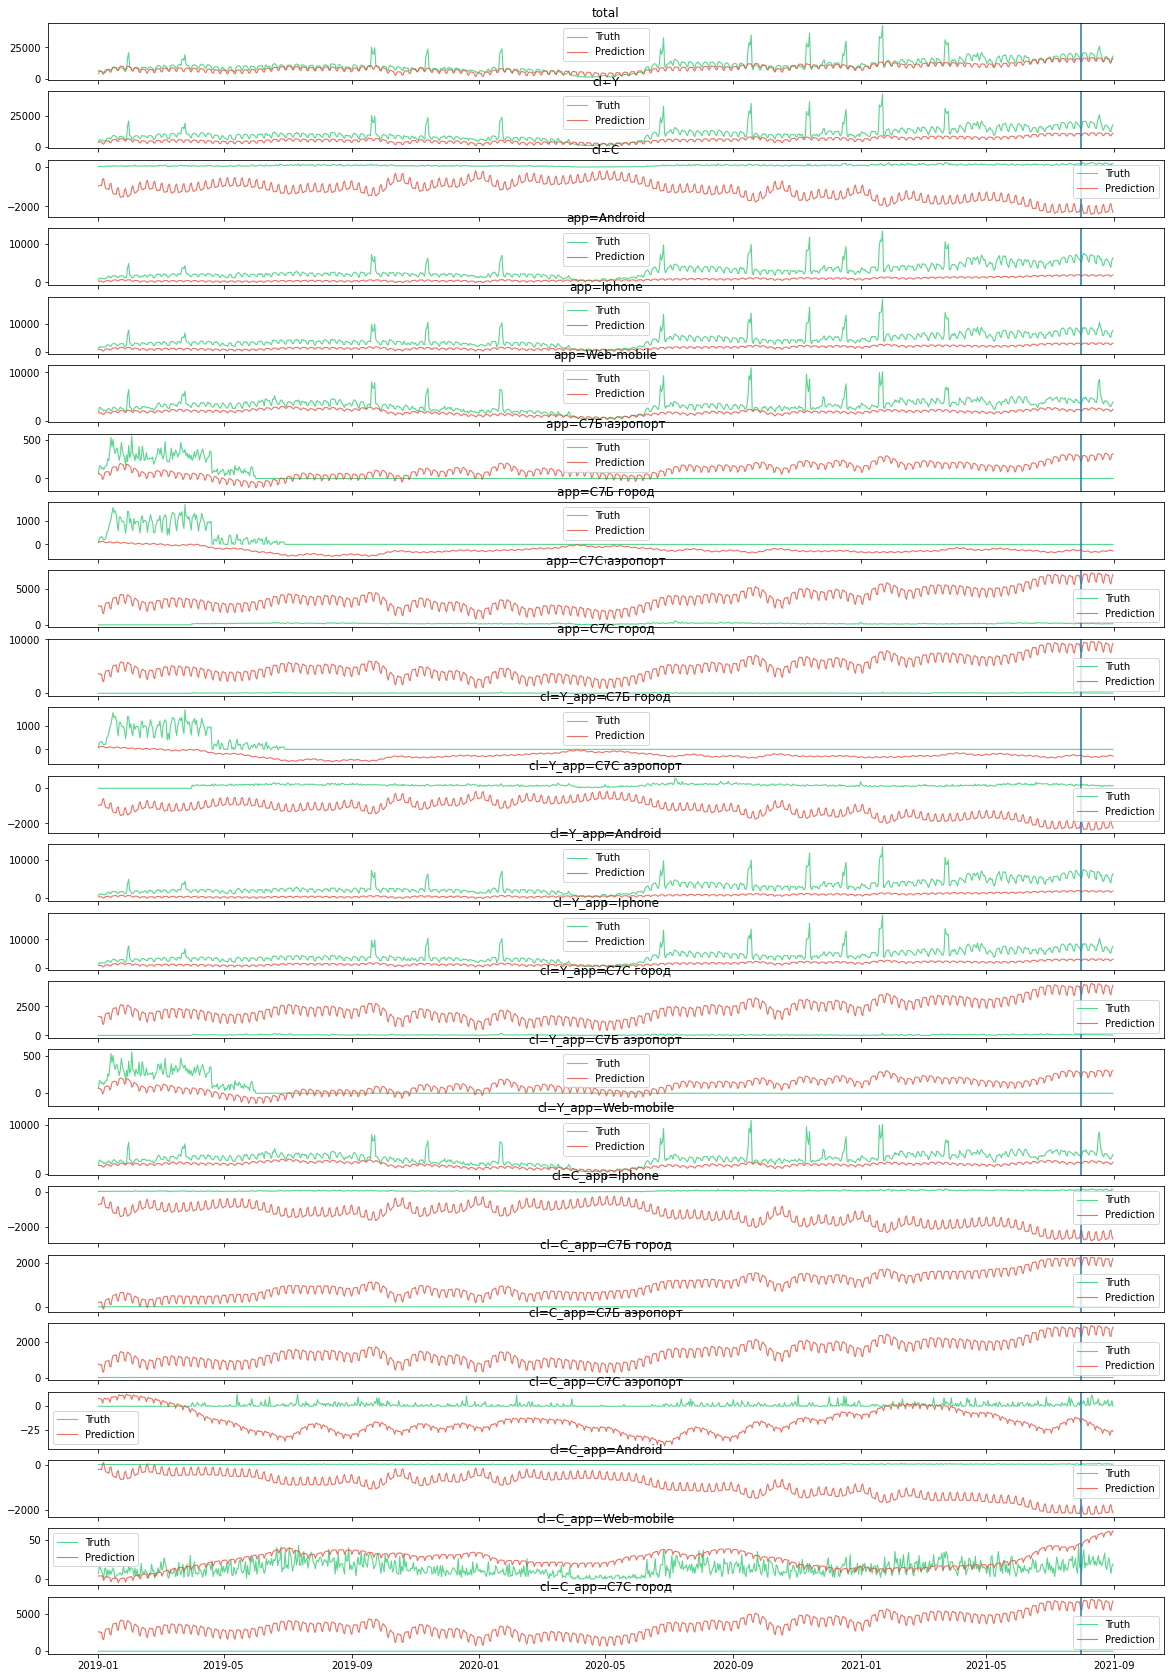

In [77]:
plot_results(grouped_df, preds, hierarchy)

## Видим, что модель очень плохо справляется даже с улавливанием тренда. Можно предположить, что с такой глубокой иерархией в датасете слишком много нулевых значений, что трудно предсказывать временным рядом, так как нули не дают никакой сезонной информации

## Построим систему проверки качества: будем обучаться на кусочке данных и сравнивать предсказание следующего дня с реальным значением

In [24]:
CHECK_POINTS = pd.to_datetime(['2019-12-01', '2020-03-01', '2020-07-01', 
                               '2020-12-01', '2021-03-01', '2021-06-01'])

def cross_val(real_df, hierarhy, method=None):
    diff_dfs = []
    
    for point in CHECK_POINTS:
        grouped_df = real_df.loc[:point, :]
        
        reg = hts.HTSRegressor(
            model='prophet',
            weekly_seasonality=True,
            daily_seasonality=True,
            yearly_seasonality=True,
            revision_method='OLS', # "OLS", "WLSS", "WLSV", "FP", "PHA", "AHP", "BU", "NONE"
        )
        reg = reg.fit(df=grouped_df, nodes=hierarchy)
        preds = reg.predict(steps_ahead=VALIDATION_DAYS)

        diff_dfs.append(pd.concat([real_df.loc[[point + pd.Timedelta(days=1)], :],
                        preds.loc[[point + pd.Timedelta(days=1)], :] \
                                  .rename(columns={col : f'preds_{col}' for col in preds.columns})], axis=1))
    
    res = diff_dfs[0]
    for df in diff_dfs[1:]:
        res = pd.concat([res, df])
    
    res['percentage_diff_total'] = abs(res.total - res.preds_total) / res.total
    return res

Тут посчитано для случая одноуровневой иерархии

In [25]:
diff_df = cross_val(grouped_df, hierarchy)

Fitting models: 100%|██████████| 8/8 [00:21<00:00,  2.65s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fcb944c6640>
Fitting models: 100%|██████████| 8/8 [00:23<00:00,  2.96s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fcb9436acd0>
Fitting models: 100%|██████████| 8/8 [00:15<00:00,  1.90s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fcb94585b50>
Fitting models: 100%|██████████| 8/8 [00:27<00:00,  3.39s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fcb940c9a00>
Fitting models: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fcb943b5c10>
Fitting models: 100%|██████████| 8/8 [00:29<00:00,  3.70s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x

In [26]:
diff_df.round(2)

,total,app=Android,app=Iphone,app=Web-mobile,app=С7Б аэропорт,app=С7Б город,app=С7С аэропорт,app=С7С город,preds_total,preds_app=Android,preds_app=Iphone,preds_app=Web-mobile,preds_app=С7Б аэропорт,preds_app=С7Б город,preds_app=С7С аэропорт,preds_app=С7С город,percentage_diff_total
2019-12-02,8491.0,2090.0,3450.0,2740.0,0.0,0.0,189.0,22.0,4189.03,-1194.93,739.28,-954.55,1536.48,-1120.51,-1226.40,6409.66,0.51
2020-03-02,6738.0,1924.0,2870.0,1743.0,0.0,0.0,152.0,49.0,2263.99,175.20,1484.31,-2070.86,6721.92,-2207.52,-2121.95,282.88,0.66
2020-07-02,13127.0,4150.0,5438.0,3198.0,0.0,0.0,235.0,106.0,11230.28,137.01,4117.50,3552.84,174.65,315.63,137.27,2795.38,0.14
2020-12-02,13185.0,3872.0,5634.0,3451.0,0.0,0.0,188.0,40.0,6103.50,10746.79,-2079.37,-2153.97,-2246.90,-2256.09,2917.22,1175.83,0.54
2021-03-02,16043.0,4651.0,6620.0,4596.0,0.0,0.0,176.0,0.0,15875.97,4380.76,6461.94,145.25,36.87,4672.86,124.20,54.11,0.01
2021-06-02,18876.0,6044.0,7360.0,5083.0,0.0,0.0,327.0,62.0,4803.27,-4498.83,-4626.77,457.91,2854.88,13887.97,-4605.24,1333.36,0.75


# Prophet без иерархии

In [27]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import os

In [28]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [40]:
hierarchy

{'total': ['app=Android',
  'app=Iphone',
  'app=Web-mobile',
  'app=С7Б аэропорт',
  'app=С7Б город',
  'app=С7С аэропорт',
  'app=С7С город']}

In [29]:
metrics = []

for TARGET in grouped_df.columns:
    params = {
        'growth': 'linear',
        'weekly_seasonality': True,
        'daily_seasonality': True,
        'yearly_seasonality': True,
        'holidays_prior_scale': 0.25,
    }

    m = Prophet(**params)
    m.add_country_holidays(country_name='RU')
    with suppress_stdout_stderr():
        m.fit(grouped_df.loc[:grouped_df.index[-1] - pd.Timedelta(days=validation_days), :][[TARGET]].reset_index().rename(columns={TARGET:'y', TIME_COL:'ds'}))

    future = m.make_future_dataframe(periods=VALIDATION_DAYS, freq='D')
    future = future.merge(grouped_df[[TARGET]], left_on='ds', right_on=TIME_COL, how='left')

    forecast = m.predict(future)

    prophet_preds = grouped_df.loc[grouped_df.index[-1] - pd.Timedelta(days=validation_days):, :].merge(forecast, left_index=True, right_on='ds', how='inner')
    
    hts_preds = grouped_df.loc[grouped_df.index[-1] - pd.Timedelta(days=validation_days):, :].merge(preds, left_index=True, right_index=True, how='inner')
    print(f'-------{TARGET}:')
    print(f'MAE common prophet = {mean_absolute_error(prophet_preds[TARGET], prophet_preds.yhat)}')
    print(f'MAE hts prophet = {mean_absolute_error(hts_preds[f"{TARGET}_x"], hts_preds[f"{TARGET}_y"])}')
    
    metrics.append([mean_absolute_error(prophet_preds[TARGET], prophet_preds.yhat), 
    mean_absolute_error(hts_preds[f'{TARGET}_x'], hts_preds[f'{TARGET}_y'])])

-------total:
MAE common prophet = 2058.6786281849145
MAE hts prophet = 2050.3358257007217
-------app=Android:
MAE common prophet = 585.6278283771207
MAE hts prophet = 589.5772371092793
-------app=Iphone:
MAE common prophet = 846.933891112573
MAE hts prophet = 844.2213820597545
-------app=Web-mobile:
MAE common prophet = 762.893415314777
MAE hts prophet = 805.4617729805271
-------app=С7Б аэропорт:
MAE common prophet = 2.76745196336131
MAE hts prophet = 19.084719632273426
-------app=С7Б город:
MAE common prophet = 23.90903200212064
MAE hts prophet = 31.807177874093618
-------app=С7С аэропорт:
MAE common prophet = 90.53602597901191
MAE hts prophet = 104.75642044817236
-------app=С7С город:
MAE common prophet = 17.510597913094642
MAE hts prophet = 28.19853226379746


### Заметим, что показатели очень близки, но в целом профет для каждого ряда по-отдельности работает стабильнее